In [97]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


# ------ Define discrete DMP class
class DiscreteDMP:
    # ------ Initialization of class
    def __init__(self, data_set, n_rbf=100, alpha_y=60, beta_y=60/4.0, alpha_x=1.0, cs_runtime=1.0):
        # Input parameters
        self.y_demo = data_set
        self.n_rbf = n_rbf
        self.data_len = len(data_set)
        self.y0 = data_set[0]
        self.g = data_set[-1]
        # Constant parameters
        self.alpha_y = alpha_y
        self.beta_y = beta_y
        self.alpha_x = alpha_x
        self.cs_runtime = cs_runtime
        self.x0 = 1.0
        self.tau_t = 1.0  # tau used during training
        # Reproduction parameters
        self.start = 0.0
        self.target = 0.0
        self.tau = 0.0
        self.x_auxiliary = self.x0
        self.y = self.y0
        self.dy = 0.0
        self.ddy = 0.0
        # Calculated parameters
        self.dt = self.cs_runtime/self.data_len
        self.time_steps = round(self.cs_runtime / self.dt)
        # The obtained parameters need to be trained
        self.w = np.zeros(self.n_rbf)
        self.psi_centers = np.zeros(self.n_rbf)
        self.psi_h = np.zeros(self.n_rbf)

        # Generate center and widths of RBFs based on the demonstration
        self.generate_rbf_centers()
        self.psi_h = np.ones(self.n_rbf) * self.n_rbf ** 1.5 / self.psi_centers / self.alpha_x  # Choose from experience
        
        # Training DMP
        self.training_rbf_weights()

    # ------ Generate the center of the RBFs
    def generate_rbf_centers(self):
        # Runtime sliced by the number of RBFs
        t_centers = np.linspace(0, self.cs_runtime, self.n_rbf)
        # Runtime sliced by the number of demo_data
        t_track = np.linspace(0, self.cs_runtime, self.time_steps)
        # The value of X sampling by the frequency of demo_data
        x_track = np.zeros(self.time_steps)
        tmp_x = self.x0
        for i in range(self.time_steps):
            x_track[i] = tmp_x
            dx = - self.alpha_x * tmp_x * self.dt
            tmp_x = tmp_x + self.tau_t * dx
        # The value of the demonstration frequency that is closest to the RBFs frequency is found,
        # and its corresponding regular system x value is used as the center of the basis function
        for n in range(len(t_centers)):
            for i, t_track_value in enumerate(t_track):
                if abs(t_centers[n] - t_track_value) <= self.dt:  # find the x center corresponding to the time center
                    self.psi_centers[n] = x_track[i]
        # return psi_centers
        return self.psi_centers

    # ------ Training the weights of the RBFs
    def training_rbf_weights(self):
        # Interpolate the demonstrated trajectory to be the same length with time_steps
        # It is equivalent to re-obtaining the demonstration on runtime space at the original frequency
        x = np.linspace(0, self.cs_runtime, len(self.y_demo))
        y = np.zeros(self.time_steps)
        y_tmp = interp1d(x, self.y_demo)
        for k in range(self.time_steps):
            y[k] = y_tmp(k * self.dt)

        # Calculate velocity and acceleration of y_demo
        dy_demo = np.gradient(y) / self.dt
        ddy_demo = np.gradient(dy_demo) / self.dt

        # same x_track
        x_track = np.zeros(self.time_steps)
        self_x = 1.0
        for i in range(self.time_steps):
            x_track[i] = self_x
            dx = - self.alpha_x * self_x * self.dt
            self_x = self_x + self.tau_t * dx

        # Calculate \bm{f}_{target}
        bm_f_target = ddy_demo - self.alpha_y * (self.beta_y * (self.g - self.y_demo) - dy_demo)

        # Calculate \bm{s}
        bm_s = np.zeros(len(self.y_demo))
        for i in range(len(bm_s)):
            bm_s[i] = x_track[i] * (self.g - self.y0)

        # Calculate \Gamma_i
        phi = np.zeros((self.n_rbf, len(self.y_demo)))
        for i in range(self.n_rbf):
            for j in range(len(self.y_demo)):
                phi[i][j] = np.exp(- self.psi_h[i] * np.square(x_track[j] - self.psi_centers[i]))
                
        # # calculated weights of rbf
        # for i in range(self.n_rbf):
        #     frac1 = np.dot(bm_s.T, np.dot(np.diag(phi[i, :]), bm_f_target))
        #     frac2 = np.dot(bm_s.T, np.dot(np.diag(phi[i, :]), bm_s))
        #     self.w[i] = frac1 / frac2
        
        # Fix division by 0 problem
        epsilon = 1e-6
        for i in range(self.n_rbf):
            frac1 = np.dot(bm_s.T, np.dot(np.diag(phi[i, :]), bm_f_target))
            frac2 = np.dot(bm_s.T, np.dot(np.diag(phi[i, :]), bm_s))
            # Add epsilon to denominator to avoid division by zero
            self.w[i] = frac1 / (frac2 + epsilon)

    # ------ Reproduction based on DMP
    def reproduction(self, start=None, target=None, tau=None, forcing=1.0):
        """Reproduce trajectory based on DMP

        Args:
            start (float, optional): Specify different starting point. Defaults to None.
            target (float, optional): Specify different ending point. Defaults to None.
            tau (float, optional): Adjust time scaling of result. Defaults to None.
            forcing (float, optional): Adjust the scaling of the output trajectory. Defaults to 1.0.

        Returns:
            _type_: _description_
        """
        epsilon = 1e-6
        
        # set temporal scaling
        if tau is None:
            time_steps = self.time_steps
        else:
            time_steps = round(self.time_steps / tau)
        # set parameters
        if start is None:
            self.start = self.y0
        else:
            self.start = start
        if target is None:
            self.target = self.g
        else:
            self.target = target
        if tau is None:
            self.tau = self.tau_t
        else:
            self.tau = tau

        # reproduce
        y_reproduce = np.zeros(time_steps)
        dy_reproduce = np.zeros(time_steps)
        ddy_reproduce = np.zeros(time_steps)
        tmp_y = self.start
        tmp_dy = 0.0
        for k in range(time_steps):
            # y_reproduce[k], dy_reproduce[k], ddy_reproduce[k] = self.step()
            dx = -self.alpha_x * self.x_auxiliary * self.dt
            self.x_auxiliary += self.tau * dx
            x = self.x_auxiliary

            # calculate force term
            psi = np.exp(-self.psi_h * (x - self.psi_centers) ** 2)
            
            forcing_scale = 2.5  # Adjust this value to match amplitude
            # f = forcing_scale * np.dot(psi, self.w) * x * (self.target - self.start) / np.sum(psi)
            f = forcing_scale * np.dot(psi, self.w) * x * (self.target - self.start) / (np.sum(psi) + epsilon)

            
            # f = np.dot(psi, self.w) * x * (self.target - self.start) / np.sum(psi)

            # calculate acc → velocity → position
            tmp_ddy = self.alpha_y * (self.beta_y * (self.target - tmp_y) - tmp_dy) + f
            tmp_dy += self.tau * tmp_ddy * self.dt
            tmp_y += self.tau * tmp_dy * self.dt
            y_reproduce[k] = tmp_y
            dy_reproduce[k] = tmp_dy
            ddy_reproduce[k] = tmp_ddy

        # return reproduce trajectory
        return y_reproduce, dy_reproduce, ddy_reproduce

In [12]:
import numpy as np

x_data = 'aligned_trajectory_data_x.csv'
x_traj_data = np.genfromtxt(x_data, delimiter=',', usecols=(0), skip_header=1)

y_data = 'aligned_trajectory_data_y.csv'
y_traj_data = np.genfromtxt(y_data, delimiter=',', usecols=(0), skip_header=1)

z_data = 'aligned_trajectory_data_z.csv'
z_traj_data = np.genfromtxt(z_data, delimiter=',', usecols=(0), skip_header=1)

print(x_traj_data.shape)
print(y_traj_data.shape)
print(z_traj_data.shape)

(1572,)
(1545,)
(1496,)


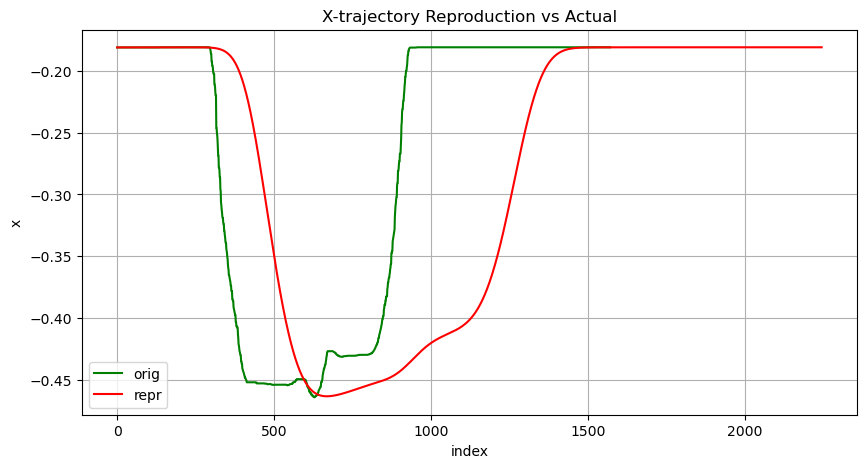

In [98]:
dmp = DiscreteDMP(data_set=x_traj_data, n_rbf=200, alpha_y=80, beta_y=80/4.0, alpha_x=0.75, cs_runtime=1)
# dmp = DiscreteDMP(data_set=x_traj_data, n_rbf=185, alpha_y=140, beta_y=140/4.0, alpha_x=0.8, cs_runtime=1)

# Doubling the time_scale (speeding up)
# y_re, dy_re, ddy_re = dmp.reproduction(tau=2.0)
# Change start and target position
# # y_re, dy_re, ddy_re = dmp.reproduction(start=1.0,target=0.2)

# Reproduction by DMP
x_re, dx_re, ddx_re = dmp.reproduction(forcing=15, tau=0.7)

# ------ Plot results
plt.figure(figsize=(10, 5))
plt.plot(x_traj_data, 'g', label='orig')
plt.plot(x_re, 'r', label='repr')
plt.legend()
plt.grid()
plt.xlabel('index')
plt.ylabel('x')
plt.title('X-trajectory Reproduction vs Actual')
plt.show()

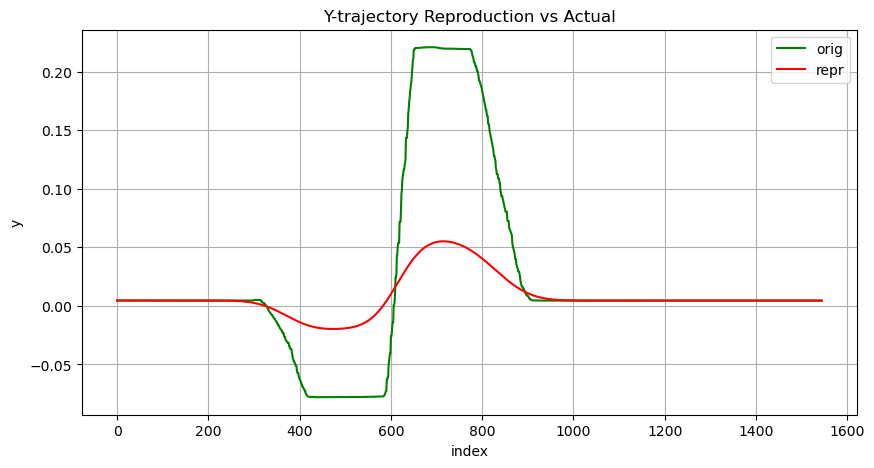

In [100]:
# dmp = DiscreteDMP(data_set=y_traj_data)
dmp = DiscreteDMP(data_set=y_traj_data, n_rbf=150, alpha_y=120, beta_y=120/4.0, alpha_x=0.95, cs_runtime=1)

# Reproduction by DMP
y_re, dy_re, ddy_re = dmp.reproduction(forcing=25)

# ------ Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_traj_data, 'g', label='orig')
plt.plot(y_re, 'r', label='repr')
plt.legend()
plt.grid()
plt.xlabel('index')
plt.ylabel('y')
plt.title('Y-trajectory Reproduction vs Actual')
plt.show()

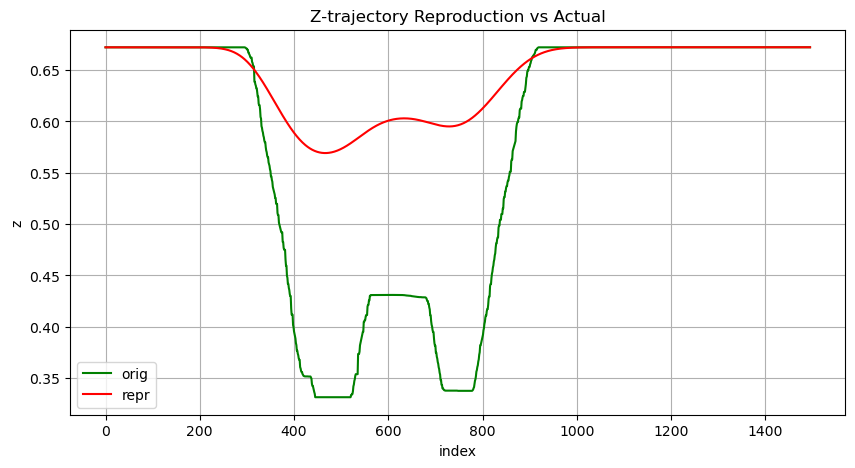

In [90]:
# dmp = DiscreteDMP(data_set=z_traj_data)
dmp = DiscreteDMP(data_set=z_traj_data, n_rbf=150, alpha_y=120, beta_y=120/4.0, alpha_x=0.95, cs_runtime=1)

# Reproduction by DMP
z_re, dz_re, ddz_re = dmp.reproduction(forcing=65)

# ------ Plot results
plt.figure(figsize=(10, 5))
plt.plot(z_traj_data, 'g', label='orig')
plt.plot(z_re, 'r', label='repr')
plt.legend()
plt.grid()
plt.xlabel('index')
plt.ylabel('z')
plt.title('Z-trajectory Reproduction vs Actual')
plt.show()